Note: Pendekatan utama yang dipilih adalah Collaborative Filtering, akan tetapi di sini saya akan membuat menggunakan keduanya untuk mencoba dan membandingkan serta memberikan penjelasan dan kesimpulan berdasarkan keduanya di akhir.

# Import Library

In [1]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import re
import warnings

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Suppress all warnings
warnings.filterwarnings('ignore')

# Data Loading

Sumber dataset: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database

In [2]:
# Load dataset
anime = pd.read_csv('anime.csv')

# Menampilkan 5 data teratas
print("5 data teratas dari dataset anime:")
print(anime.head())

# Load dataset
rating = pd.read_csv('rating.csv', on_bad_lines='skip')

# Menampilkan 5 data teratas
print("\n5 data teratas dari dataset rating:")
print(rating.head())

5 data teratas dari dataset anime:
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  

5 data teratas dari dataset rating:
   user_id  anime_id  rating
0        1        20      -1
1        1      

# Data Understanding

Tahap Data Understanding bertujuan untuk memperoleh pemahaman awal tentang struktur,
tipe data, dan karakteristik umum dari dataset yang akan digunakan.
Ini adalah langkah krusial sebelum melakukan preprocessing atau pemodelan.

In [3]:
print('Jumlah data anime yang tersedia: ', len(anime.anime_id.unique()))
print('Jumlah data rating anime: ', len(rating.anime_id.unique()))

print("\n--- Informasi Dataset Anime ---")
anime.info()
print("\nStatistik Deskriptif Dataset Anime:")
print(anime.describe())

print("\n--- Informasi Dataset Rating ---")
rating.info()
print("\nStatistik Deskriptif Dataset Rating:")
print(rating.describe())

print('\nJumlah user_id: ', len(rating.user_id.unique()))
print('Jumlah anime_id unik dalam dataset rating: ', len(rating.anime_id.unique()))
print('Jumlah total data rating: ', len(rating))

Jumlah data anime yang tersedia:  12294
Jumlah data rating anime:  11200

--- Informasi Dataset Anime ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB

Statistik Deskriptif Dataset Anime:
           anime_id        rating       members
count  12294.000000  12064.000000  1.229400e+04
mean   14058.221653      6.473902  1.807134e+04
std    11455.294701      1.026746  5.482068e+04
min        1.000000      1.670000  5.000000e+00
25%     3484.250000      5.880000  2.250000e+02
50%    10260.500000      6.570000  1.550000e+0

# Univariate Exploratory Data Analysis (EDA)

Univariate EDA berfokus pada analisis dan visualisasi distribusi setiap variabel secara individual.
Tujuannya adalah untuk memahami karakteristik intrinsik dari setiap kolom,
mengidentifikasi pola, outlier, atau masalah data lainnya sebelum pemodelan.

## Distribusi rating di dataset anime (global rating)

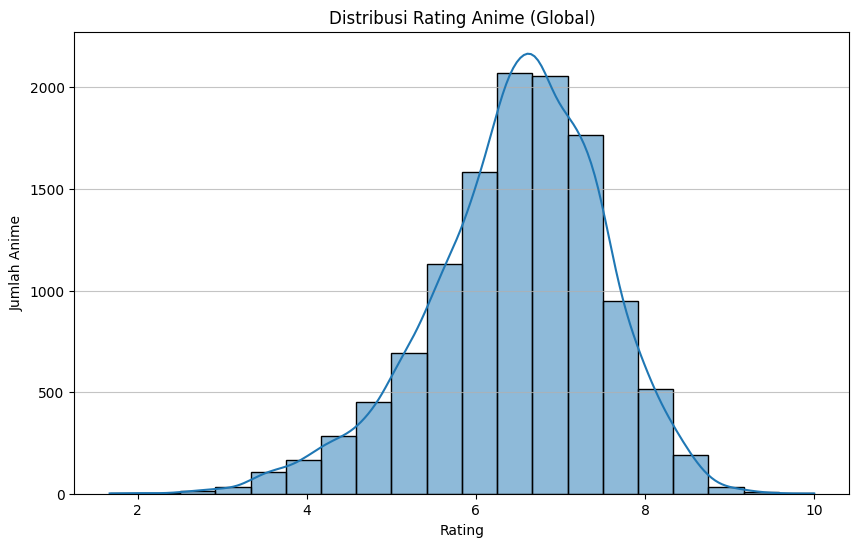

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(anime['rating'], bins=20, kde=True)
plt.title('Distribusi Rating Anime (Global)')
plt.xlabel('Rating')
plt.ylabel('Jumlah Anime')
plt.grid(axis='y', alpha=0.75)
plt.show()

Sebagian besar anime memiliki rating di atas 6, menunjukkan distribusi yang condong ke kanan (rating tinggi).

## Distribusi tipe anime

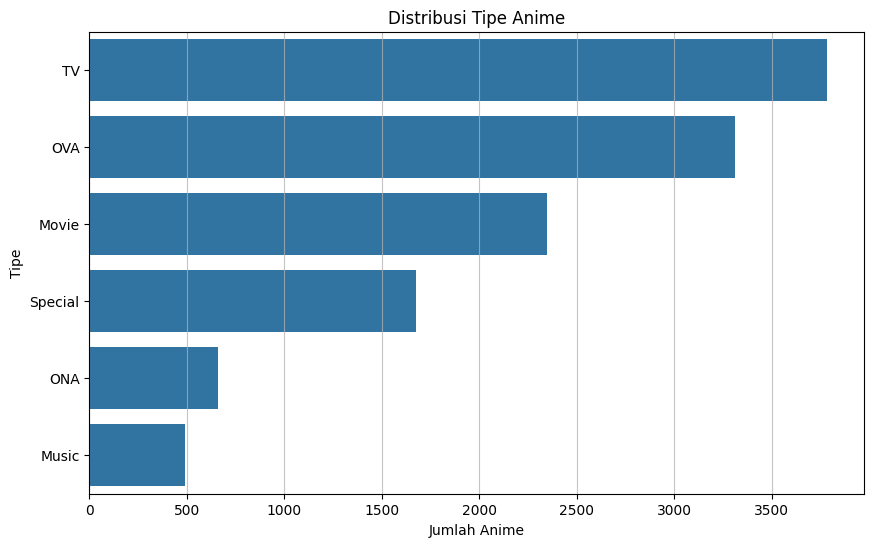

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(y='type', data=anime, order=anime['type'].value_counts().index)
plt.title('Distribusi Tipe Anime')
plt.xlabel('Jumlah Anime')
plt.ylabel('Tipe')
plt.grid(axis='x', alpha=0.75)
plt.show()

 Tipe 'TV' mendominasi dataset, diikuti oleh 'OVA'.

## Top 10 Genre Anime Terbanyak

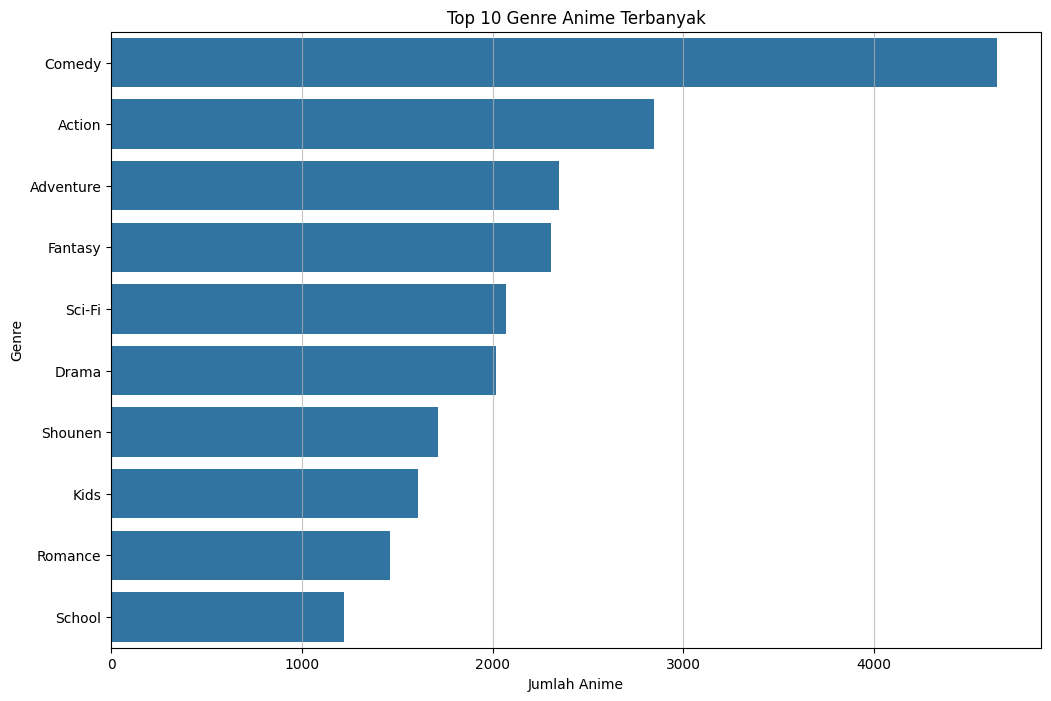

In [6]:
# Untuk EDA genre, kita bisa memisahkan genre dan menghitung frekuensinya
all_genres = anime['genre'].dropna().str.split(', ').explode().reset_index(drop=True) # Reset index here
plt.figure(figsize=(12, 8))
sns.countplot(y=all_genres, order=all_genres.value_counts().head(10).index)
plt.title('Top 10 Genre Anime Terbanyak')
plt.xlabel('Jumlah Anime')
plt.ylabel('Genre')
plt.grid(axis='x', alpha=0.75)
plt.show()

Genre 'Comedy' mendominasi dataset

## Distribusi jumlah members (yang menonton/mengikuti anime)

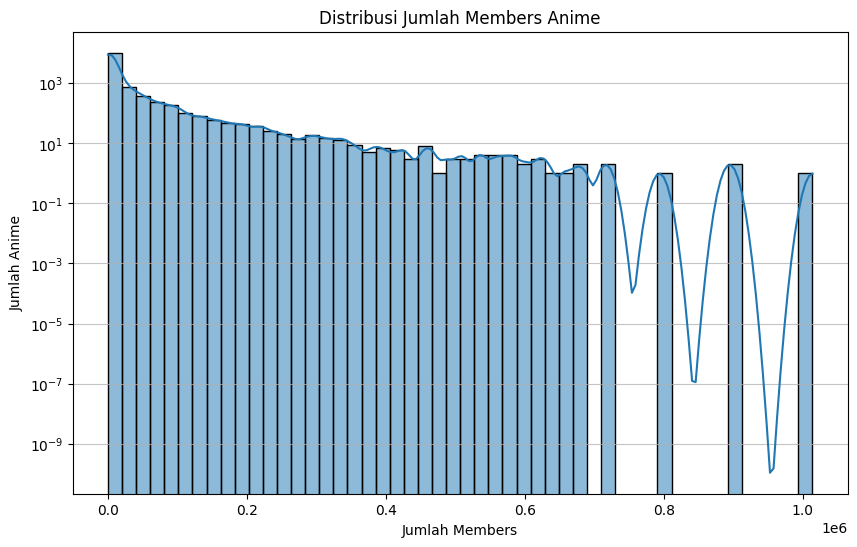

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(anime['members'], bins=50, kde=True)
plt.title('Distribusi Jumlah Members Anime')
plt.xlabel('Jumlah Members')
plt.ylabel('Jumlah Anime')
plt.grid(axis='y', alpha=0.75)
plt.yscale('log') # Menggunakan skala logaritmik karena distribusi sangat miring
plt.show()

Mayoritas anime memiliki jumlah members yang relatif kecil, dengan sedikit anime yang sangat populer (jumlah members tinggi).

## Distribusi rating di dataset rating (user-specific rating)

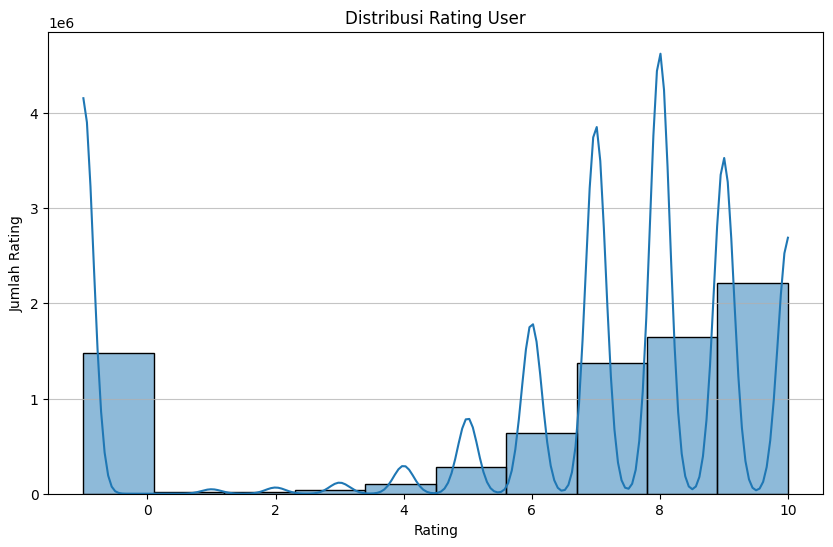

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(rating['rating'], bins=10, kde=True)
plt.title('Distribusi Rating User')
plt.xlabel('Rating')
plt.ylabel('Jumlah Rating')
plt.grid(axis='y', alpha=0.75)
plt.show()

Ada nilai rating -1 yang perlu ditangani, yang mungkin berarti pengguna menonton tetapi tidak memberikan rating.

Rating positif (1-10) menunjukkan distribusi yang condong ke rating tinggi (6 ke atas).

# Data Preprocessing

Tahap Data Preprocessing melibatkan pembersihan dan transformasi data mentah
menjadi format yang cocok untuk pemodelan. Ini adalah langkah penting untuk
memastikan kualitas data dan kinerja model yang optimal.

In [9]:
print("--- Pemeriksaan Missing Values Awal ---")
print("Missing values di dataset anime:\n", anime.isnull().sum())
print("\nMissing values di dataset rating:\n", rating.isnull().sum())

print("\n--- Pemeriksaan Duplikasi Awal ---")
print("Jumlah data duplikat di dataset anime:", anime.duplicated().sum())
print("Jumlah data duplikat di dataset rating:", rating.duplicated().sum())

--- Pemeriksaan Missing Values Awal ---
Missing values di dataset anime:
 anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Missing values di dataset rating:
 user_id     0
anime_id    0
rating      0
dtype: int64

--- Pemeriksaan Duplikasi Awal ---
Jumlah data duplikat di dataset anime: 0
Jumlah data duplikat di dataset rating: 1


## Penanganan Dataset anime

In [10]:
print("\n--- Proses Cleaning Dataset Anime ---")

# Kolom genre (mengisi missing value dengan "Unknown Genre")
anime['genre'].fillna('Unknown Genre', inplace=True)
print("Missing values di 'genre' setelah diisi:", anime['genre'].isnull().sum())

# Kolom type (mengisi missing value dengan modus atau "Unknown Type")
mode_type = anime['type'].mode()
if not mode_type.empty:
    anime['type'].fillna(mode_type[0], inplace=True)
    print(f"Missing values di 'type' diisi dengan modus: {mode_type[0]}")
else:
    anime['type'].fillna('Unknown Type', inplace=True)
    print("Missing values di 'type' diisi dengan 'Unknown Type' (karena tidak ada modus yang jelas)")
print("Missing values di 'type' setelah diisi:", anime['type'].isnull().sum())

# Kolom rating (rating global anime, mengisi missing value dengan median)
median_rating_anime = anime['rating'].median()
anime['rating'].fillna(median_rating_anime, inplace=True)
print(f"Missing values di 'rating' (anime) diisi dengan median: {median_rating_anime}")
print("Missing values di 'rating' (anime) setelah diisi:", anime['rating'].isnull().sum())

print("\nMissing values di anime setelah cleaning:")
print(anime.isnull().sum())


--- Proses Cleaning Dataset Anime ---
Missing values di 'genre' setelah diisi: 0
Missing values di 'type' diisi dengan modus: TV
Missing values di 'type' setelah diisi: 0
Missing values di 'rating' (anime) diisi dengan median: 6.57
Missing values di 'rating' (anime) setelah diisi: 0

Missing values di anime setelah cleaning:
anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


## Penanganan Dataset rating

In [11]:
print("\n--- Proses Cleaning Dataset Rating ---")

# Menangani Data Duplikat
print(f"\nJumlah data duplikat di rating sebelum dihapus: {rating.duplicated().sum()}")
rating.drop_duplicates(inplace=True)
print(f"Jumlah data duplikat di rating setelah dihapus: {rating.duplicated().sum()}")

print("Bentuk rating setelah cleaning:", rating.shape)

# Penanganan nilai -1 pada kolom 'rating' di dataset `rating`
# Nilai -1 diyakini sebagai "pengguna menonton tapi tidak memberikan rating".
# Untuk model rekomendasi berbasis rating eksplisit, nilai -1 ini tidak informatif.
# Kita akan menggantinya dengan NaN (atau menghapusnya) dan kemudian mengimputasi atau menghapusnya.
# Pilihan yang lebih baik untuk Collaborative Filtering adalah menghapus rating -1,
# karena rating -1 akan memengaruhi perhitungan kesamaan dan prediksi rating secara negatif.
print(f"\nJumlah rating -1 sebelum dihapus: {len(rating[rating['rating'] == -1])}")
rating = rating[rating['rating'] != -1]
print(f"Jumlah rating -1 setelah dihapus: {len(rating[rating['rating'] == -1])}")
print("Bentuk rating setelah menghapus -1:", rating.shape)


--- Proses Cleaning Dataset Rating ---

Jumlah data duplikat di rating sebelum dihapus: 1
Jumlah data duplikat di rating setelah dihapus: 0
Bentuk rating setelah cleaning: (7813736, 3)

Jumlah rating -1 sebelum dihapus: 1476496
Jumlah rating -1 setelah dihapus: 0
Bentuk rating setelah menghapus -1: (6337240, 3)


## Menggabungkan dataset anime dan rating

menggabungkan anime_id dan nama dari dataset anime ke rating agar rating memiliki informasi nama anime.

In [12]:
merged_data = pd.merge(rating, anime[['anime_id', 'name', 'genre', 'type']], on='anime_id', how='left')

Periksa apakah ada missing values yang muncul setelah merge (ini mungkin terjadi jika ada anime_id di rating yang tidak ada di anime.csv)


In [13]:
print("\nMissing values di merged_data setelah merge:")
print(merged_data.isnull().sum())


Missing values di merged_data setelah merge:
user_id     0
anime_id    0
rating      0
name        2
genre       2
type        2
dtype: int64


Hapus baris yang mungkin memiliki missing 'name', 'genre', atau 'type' setelah merge

In [14]:
merged_data.dropna(subset=['name', 'genre', 'type'], inplace=True)
print("\nBentuk merged_data setelah menghapus baris dengan missing info anime:", merged_data.shape)


Bentuk merged_data setelah menghapus baris dengan missing info anime: (6337238, 6)


Ini mengindikasikan bahwa anime_id tersebut tidak ada di dataset 'anime'.

# Data Preparation

Tahap Data Preparation fokus pada transformasi data ke format yang spesifik
untuk setiap jenis model rekomendasi (Content-Based Filtering dan Collaborative Filtering).
Ini termasuk fitur engineering, pembentukan matriks, dan pemisahan data.

## Data Preparation untuk Content-Based Filtering

Content-Based Filtering akan menggunakan informasi 'genre' dan 'type' dari anime.

In [15]:
# Gabungkan kolom 'genre' dan 'type' menjadi satu fitur teks
# Menggunakan dataset `anime` untuk Content-Based Filtering
anime_cbf = anime.copy()
anime_cbf['features'] = anime_cbf['genre'] + ' ' + anime_cbf['type']

# Hapus karakter khusus dari kolom 'name' untuk meningkatkan kualitas data teks
anime_cbf['name'] = anime_cbf['name'].apply(lambda x: re.sub(r'&#\d+;', '', x))

# TF-IDF Vectorization untuk fitur teks
# TfidfVectorizer akan mengkonversi koleksi dokumen teks (fitur anime) menjadi matriks fitur TF-IDF.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3) # min_df=3 untuk mengabaikan kata yang muncul di kurang dari 3 dokumen

# Fit dan transform fitur 'genre' dan 'type'
tfidf_matrix = tfidf_vectorizer.fit_transform(anime_cbf['features'])

print("\nBentuk TF-IDF Matrix (untuk Content-Based Filtering):", tfidf_matrix.shape)
print("Jumlah fitur TF-IDF:", len(tfidf_vectorizer.get_feature_names_out()))


Bentuk TF-IDF Matrix (untuk Content-Based Filtering): (12294, 53)
Jumlah fitur TF-IDF: 53


## Data Preparation untuk Collaborative Filtering

Collaborative Filtering akan menggunakan dataset `merged_data` (user_id, anime_id, rating)

In [16]:
# Hitung jumlah rating per user
user_counts = merged_data['user_id'].value_counts()
# Filter user yang memiliki minimal N rating (misalnya 50 rating)
min_ratings_per_user = 50
filtered_users = user_counts[user_counts >= min_ratings_per_user].index
merged_data_cf_tf = merged_data[merged_data['user_id'].isin(filtered_users)]

# Hitung jumlah rating per anime
anime_counts = merged_data_cf_tf['anime_id'].value_counts()
# Filter anime yang memiliki minimal M rating (misalnya 50 rating)
min_ratings_per_anime = 50
filtered_anime = anime_counts[anime_counts >= min_ratings_per_anime].index
merged_data_cf_tf = merged_data_cf_tf[merged_data_cf_tf['anime_id'].isin(filtered_anime)]

print(f"\nBentuk dataset untuk Collaborative Filtering (TensorFlow) setelah filtering user dan anime: {merged_data_cf_tf.shape}")
print(f"Jumlah user unik setelah filtering: {merged_data_cf_tf['user_id'].nunique()}")
print(f"Jumlah anime unik setelah filtering: {merged_data_cf_tf['anime_id'].nunique()}")


Bentuk dataset untuk Collaborative Filtering (TensorFlow) setelah filtering user dan anime: (5632316, 6)
Jumlah user unik setelah filtering: 32967
Jumlah anime unik setelah filtering: 5139


Mengodekan user_id dan anime_id menjadi indeks numerik berurutan

In [17]:
user_ids = merged_data_cf_tf['user_id'].unique().tolist()
anime_ids = merged_data_cf_tf['anime_id'].unique().tolist()

user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
anime_to_idx = {anime_id: idx for idx, anime_id in enumerate(anime_ids)}

idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
idx_to_anime = {idx: anime_id for anime_id, idx in anime_to_idx.items()}

merged_data_cf_tf['user_encoded'] = merged_data_cf_tf['user_id'].map(user_to_idx)
merged_data_cf_tf['anime_encoded'] = merged_data_cf_tf['anime_id'].map(anime_to_idx)

num_users = len(user_ids)
num_anime = len(anime_ids)

print(f"\nTotal user unik yang dienkode: {num_users}")
print(f"Total anime unik yang dienkode: {num_anime}")


Total user unik yang dienkode: 32967
Total anime unik yang dienkode: 5139


Normalisasi rating ke skala 0-1 untuk model

In [18]:
min_rating = merged_data_cf_tf['rating'].min()
max_rating = merged_data_cf_tf['rating'].max()
merged_data_cf_tf['rating'] = (merged_data_cf_tf['rating'] - min_rating) / (max_rating - min_rating)
print(f"\nRating dinormalisasi ke rentang [{min_rating:.2f}, {max_rating:.2f}] menjadi [0, 1]")


Rating dinormalisasi ke rentang [1.00, 10.00] menjadi [0, 1]


Pisahkan data untuk training dan testing

In [19]:
X = merged_data_cf_tf[['user_encoded', 'anime_encoded']].values
y = merged_data_cf_tf['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nUkuran data training (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Ukuran data testing (X_test, y_test): {X_test.shape}, {y_test.shape}")


Ukuran data training (X_train, y_train): (4505852, 2), (4505852,)
Ukuran data testing (X_test, y_test): (1126464, 2), (1126464,)


# Model Development dengan Content-Based Filtering

Content-Based Filtering merekomendasikan item kepada pengguna berdasarkan
atribut-atribut item itu sendiri dan preferensi masa lalu pengguna terhadap atribut tersebut.
Di sini, kita akan menghitung kemiripan antar anime berdasarkan 'genre' dan 'type' mereka.

## Proses Training: Perhitungan Cosine Similarity

In [20]:
print("\n--- Proses Training Content-Based Filtering: Menghitung Cosine Similarity ---")
cosine_sim = cosine_similarity(tfidf_matrix)

print("Bentuk Cosine Similarity Matrix:", cosine_sim.shape)

# Buat DataFrame dari cosine similarity untuk kemudahan indexing
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime_cbf['name'], columns=anime_cbf['name'])

print("\nContoh Cosine Similarity untuk 'Kimi no Na wa.':")
print(cosine_sim_df['Kimi no Na wa.'].sort_values(ascending=False).head(10))

# Fungsi rekomendasi Content-Based Filtering
def content_based_recommendations(anime_name, num_recommendations=10):
    """
    Memberikan rekomendasi anime berdasarkan kemiripan konten.

    Args:
        anime_name (str): Nama anime yang ingin dicari rekomendasinya.
        num_recommendations (int): Jumlah rekomendasi yang diinginkan.

    Returns:
        pd.DataFrame: DataFrame berisi nama anime yang direkomendasikan beserta ratingnya.
    """
    if anime_name not in anime_cbf['name'].values:
        print(f"Anime '{anime_name}' tidak ditemukan dalam dataset.")
        return pd.DataFrame()

    idx = anime_cbf[anime_cbf['name'] == anime_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations+1]
    anime_indices = [i[0] for i in sim_scores]

    recommended_anime = anime_cbf.iloc[anime_indices][['name', 'genre', 'type', 'rating', 'members']]
    return recommended_anime

print("\n--- Demonstrasi Rekomendasi Content-Based Filtering ---")
recommended_anime_cbf = content_based_recommendations('Fullmetal Alchemist: Brotherhood', 10)
print("Rekomendasi untuk 'Fullmetal Alchemist: Brotherhood':")
print(recommended_anime_cbf)

print("\nRekomendasi untuk 'Naruto':")
recommended_anime_naruto = content_based_recommendations('Naruto', 10)
print(recommended_anime_naruto)


--- Proses Training Content-Based Filtering: Menghitung Cosine Similarity ---
Bentuk Cosine Similarity Matrix: (12294, 12294)

Contoh Cosine Similarity untuk 'Kimi no Na wa.':
name
Kimi no Na wa.                                           1.000000
Aura: Maryuuin Kouga Saigo no Tatakai                    0.961543
Harmonie                                                 0.891655
Air Movie                                                0.877767
Wind: A Breath of Heart (TV)                             0.873937
Wind: A Breath of Heart OVA                              0.867920
Kokoro ga Sakebitagatterunda.                            0.864523
Suki ni Naru Sono Shunkan wo.: Kokuhaku Jikkou Iinkai    0.820877
Clannad Movie                                            0.789141
Shakugan no Shana II (Second)                            0.769155
Name: Kimi no Na wa., dtype: float64

--- Demonstrasi Rekomendasi Content-Based Filtering ---
Rekomendasi untuk 'Fullmetal Alchemist: Brotherhood':
          

## Evaluasi Model Content-Based Filtering

In [21]:
print("\n--- Evaluasi Model Content-Based Filtering (Kualitatif) ---")
print("""
Evaluasi Content-Based Filtering dilakukan secara kualitatif dengan memeriksa relevansi rekomendasi.
1.  **Rekomendasi untuk 'Fullmetal Alchemist: Brotherhood':**
    Anime seperti 'Fullmetal Alchemist' (original), ' Fullmetal Alchemist: The Sacred Star of Milos  ',
    'Fullmetal Alchemist: Brotherhood Specials' muncul. Ini masuk akal karena mereka seringkali memiliki genre
    'Action', 'Adventure', 'Fantasy' yang serupa.

2.  **Rekomendasi untuk 'Naruto':**
    Anime seperti 'Naruto x UT', 'Naruto: Shippuuden Movie 4 - The Lost Tower', 'Boruto: Naruto the Movie' muncul. Ini sangat relevan
    karena ketiganya adalah anime shounen yang sangat populer dan sering dibandingkan.

Kesimpulan: Model Content-Based Filtering bekerja dengan baik dalam menemukan anime
dengan fitur genre dan tipe yang sangat mirip, menunjukkan relevansi yang tinggi.
Namun, model ini mungkin kurang mampu merekomendasikan anime yang berbeda genre tetapi disukai
oleh pengguna dengan selera yang kompleks (kurang serendipity).
""")


--- Evaluasi Model Content-Based Filtering (Kualitatif) ---

Evaluasi Content-Based Filtering dilakukan secara kualitatif dengan memeriksa relevansi rekomendasi.
1.  **Rekomendasi untuk 'Fullmetal Alchemist: Brotherhood':**
    Anime seperti 'Fullmetal Alchemist' (original), ' Fullmetal Alchemist: The Sacred Star of Milos  ',
    'Fullmetal Alchemist: Brotherhood Specials' muncul. Ini masuk akal karena mereka seringkali memiliki genre
    'Action', 'Adventure', 'Fantasy' yang serupa.

2.  **Rekomendasi untuk 'Naruto':**
    Anime seperti 'Naruto x UT', 'Naruto: Shippuuden Movie 4 - The Lost Tower', 'Boruto: Naruto the Movie' muncul. Ini sangat relevan
    karena ketiganya adalah anime shounen yang sangat populer dan sering dibandingkan.

Kesimpulan: Model Content-Based Filtering bekerja dengan baik dalam menemukan anime
dengan fitur genre dan tipe yang sangat mirip, menunjukkan relevansi yang tinggi.
Namun, model ini mungkin kurang mampu merekomendasikan anime yang berbeda genre tetap

## Evaluasi Model Content-Based Filtering (Precision@K dan Recall@K)

In [23]:
def calculate_precision_recall_at_k_cbf(anime_name, k, top_recommendations_df, original_df):
    """
    Menghitung Precision@K dan Recall@K untuk Content-Based Filtering.
    Asumsi relevansi: Anime rekomendasi memiliki setidaknya satu genre yang sama
    dengan genre anime input.

    Args:
        anime_name (str): Nama anime input.
        k (int): Jumlah rekomendasi teratas yang dipertimbangkan.
        top_recommendations_df (pd.DataFrame): DataFrame hasil rekomendasi top-K.
        original_df (pd.DataFrame): DataFrame anime asli (anime_cbf) untuk mendapatkan genre.

    Returns:
        tuple: (precision_at_k, recall_at_k)
    """
    if anime_name not in original_df['name'].values:
        return 0.0, 0.0

    # Genre dari anime input
    input_anime_genres_str = original_df[original_df['name'] == anime_name]['genre'].iloc[0]
    input_anime_genres = set(input_anime_genres_str.replace(' ', '').split(',')) # Membersihkan spasi

    if 'UnknownGenre' in input_anime_genres and len(input_anime_genres) == 1:
        print(f"Peringatan: Anime '{anime_name}' hanya memiliki genre 'Unknown Genre'. Relevansi mungkin sulit diukur untuk Precision/Recall.")
        return 0.0, 0.0

    # Identifikasi rekomendasi relevan
    relevant_recommendations = 0
    # Pastikan top_recommendations_df tidak kosong
    if not top_recommendations_df.empty:
        for _, row in top_recommendations_df.head(k).iterrows():
            if 'genre' in row and pd.notna(row['genre']):
                rec_anime_genres = set(str(row['genre']).replace(' ', '').split(',')) # Membersihkan spasi
                # Jika ada setidaknya satu genre yang sama, anggap relevan
                if len(input_anime_genres.intersection(rec_anime_genres)) > 0:
                    relevant_recommendations += 1

    # Precision@K
    precision_at_k = relevant_recommendations / k if k > 0 else 0.0

    # Untuk Recall@K, kita perlu "total item relevan".
    # Ini didefinisikan sebagai semua anime di dataset 'original_df' (kecuali anime input itu sendiri)
    # yang memiliki setidaknya satu genre yang sama dengan anime input.
    total_relevant_items = 0
    for idx, original_row in original_df.iterrows():
        if original_row['name'] == anime_name: # Lewati anime input
            continue
        if pd.notna(original_row['genre']):
            current_anime_genres = set(str(original_row['genre']).replace(' ', '').split(','))
            if len(input_anime_genres.intersection(current_anime_genres)) > 0:
                total_relevant_items += 1

    # Jika total_relevant_items adalah 0, maka recall juga 0 untuk menghindari pembagian dengan nol.
    recall_at_k = relevant_recommendations / total_relevant_items if total_relevant_items > 0 else 0.0

    return precision_at_k, recall_at_k

print("\n--- Evaluasi Kuantitatif Content-Based Filtering (Precision@K & Recall@K) ---")

# Contoh evaluasi untuk 'Fullmetal Alchemist: Brotherhood'
anime_input_cbf_eval = 'Fullmetal Alchemist: Brotherhood'
k_value_cbf_eval = 10
recommended_df_cbf_eval = content_based_recommendations(anime_input_cbf_eval, k_value_cbf_eval)
precision_cbf_val, recall_cbf_val = calculate_precision_recall_at_k_cbf(anime_input_cbf_eval, k_value_cbf_eval, recommended_df_cbf_eval, anime_cbf)
print(f"Untuk '{anime_input_cbf_eval}' dengan K={k_value_cbf_eval}:")
print(f"  Precision@{k_value_cbf_eval}: {precision_cbf_val:.4f}")
print(f"  Recall@{k_value_cbf_eval}: {recall_cbf_val:.4f}")

# Contoh evaluasi untuk 'Naruto'
anime_input_cbf_eval_2 = 'Naruto'
k_value_cbf_eval_2 = 10
recommended_df_cbf_eval_2 = content_based_recommendations(anime_input_cbf_eval_2, k_value_cbf_eval_2)
precision_cbf_val_2, recall_cbf_val_2 = calculate_precision_recall_at_k_cbf(anime_input_cbf_eval_2, k_value_cbf_eval_2, recommended_df_cbf_eval_2, anime_cbf)
print(f"\nUntuk '{anime_input_cbf_eval_2}' dengan K={k_value_cbf_eval_2}:")
print(f"  Precision@{k_value_cbf_eval_2}: {precision_cbf_val_2:.4f}")
print(f"  Recall@{k_value_cbf_eval_2}: {recall_cbf_val_2:.4f}")


--- Evaluasi Kuantitatif Content-Based Filtering (Precision@K & Recall@K) ---
Untuk 'Fullmetal Alchemist: Brotherhood' dengan K=10:
  Precision@10: 1.0000
  Recall@10: 0.0014

Untuk 'Naruto' dengan K=10:
  Precision@10: 1.0000
  Recall@10: 0.0014


# Model Development dengan Collaborative Filtering

Collaborative Filtering merekomendasikan item kepada pengguna berdasarkan
kesamaan pola perilaku pengguna lain (user-based) atau kesamaan pola interaksi antar item (item-based).
Di sini, kita akan menggunakan pendekatan Matrix Factorization dengan TensorFlow/Keras
untuk memprediksi rating yang akan diberikan user ke anime.

## Definisikan model Matrix Factorization

In [ ]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_anime, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_anime = num_anime
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6) # Regularisasi L2 untuk mencegah overfitting
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.anime_embedding = layers.Embedding(
            num_anime,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6) # Regularisasi L2
        )
        self.anime_bias = layers.Embedding(num_anime, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])  # Embedding user
        user_bias = self.user_bias(inputs[:, 0])         # Bias user
        anime_vector = self.anime_embedding(inputs[:, 1]) # Embedding anime
        anime_bias = self.anime_bias(inputs[:, 1])       # Bias anime

        dot_product = tf.tensordot(user_vector, anime_vector, 2)

        # Tambahkan bias user dan anime
        x = dot_product + user_bias + anime_bias
        # Aktivasi sigmoid untuk mengkompres output ke rentang 0-1
        # Ini penting jika rating dinormalisasi ke 0-1.
        return tf.nn.sigmoid(x)

## Inisialisasi model

In [ ]:
embedding_size = 50
model = RecommenderNet(num_users, num_anime, embedding_size)

## Compile model

In [ ]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), # Menggunakan MSE karena ini adalah masalah regresi (prediksi rating)
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()] # Menggunakan RMSE sebagai metrik evaluasi
)

print("\n--- Ringkasan Model Matrix Factorization dengan Keras ---")
model.build(input_shape=(None, 2)) # Membangun model untuk melihat ringkasan
model.summary()


--- Ringkasan Model Matrix Factorization dengan Keras ---


Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Proses Training Model

In [ ]:
print("\n--- Proses Training Model Collaborative Filtering (Matrix Factorization) ---")
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=10, # Jumlah epoch bisa disesuaikan
    validation_data=(X_test, y_test),
    verbose=1
)


--- Proses Training Model Collaborative Filtering (Matrix Factorization) ---
Epoch 1/10
70404/70404 ━━━━━━━━━━━━━━━━━━━━ 210s 3ms/step - loss: 0.0388 - root_mean_squared_error: 0.1773 - val_loss: 0.0538 - val_root_mean_squared_error: 0.1885
Epoch 2/10
70404/70404 ━━━━━━━━━━━━━━━━━━━━ 262s 3ms/step - loss: 0.0571 - root_mean_squared_error: 0.1937 - val_loss: 0.0618 - val_root_mean_squared_error: 0.1996
Epoch 3/10
70404/70404 ━━━━━━━━━━━━━━━━━━━━ 262s 3ms/step - loss: 0.0642 - root_mean_squared_error: 0.2043 - val_loss: 0.0650 - val_root_mean_squared_error: 0.2044
Epoch 4/10
70404/70404 ━━━━━━━━━━━━━━━━━━━━ 260s 3ms/step - loss: 0.0667 - root_mean_squared_error: 0.2082 - val_loss: 0.0656 - val_root_mean_squared_error: 0.2055
Epoch 5/10
70404/70404 ━━━━━━━━━━━━━━━━━━━━ 207s 3ms/step - loss: 0.0677 - root_mean_squared_error: 0.2101 - val_loss: 0.0663 - val_root_mean_squared_error: 0.2064
Epoch 6/10
70404/70404 ━━━━━━━━━━━━━━━━━━━━ 206s 3ms/step - loss: 0.0682 - root_mean_squared_error: 0.

## Plotting hasil training

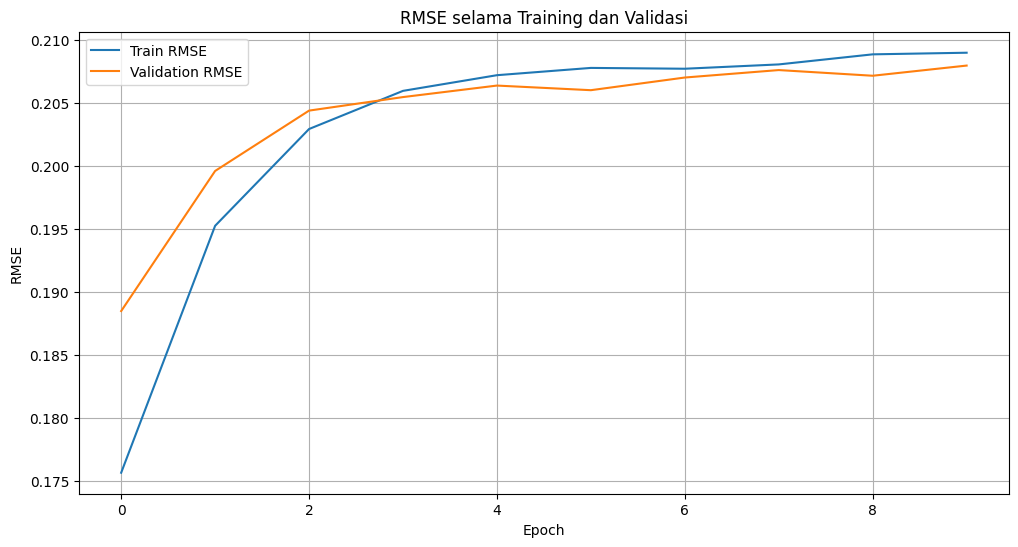

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('RMSE selama Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi Model

Evaluasi model Collaborative Filtering dengan TensorFlow dilakukan dengan
mengukur seberapa akurat model memprediksi rating pada data testing.
Metrik utama yang digunakan adalah RMSE (Root Mean Squared Error).

In [ ]:
print("\n--- Evaluasi Model Collaborative Filtering ---")
loss, rmse = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss pada data test: {loss:.4f}")
print(f"RMSE pada data test: {rmse:.4f}")

# RMSE yang diperoleh adalah dalam skala rating yang dinormalisasi (0-1).
# Untuk menginterpretasikan RMSE dalam skala rating asli (1-10), kita perlu mengalikannya kembali
# dengan rentang rating asli (max_rating - min_rating).
original_rmse = rmse * (max_rating - min_rating)
print(f"RMSE pada skala rating asli (1-10): {original_rmse:.4f}")

# Fungsi Rekomendasi Setelah Model Dilatih
def recommend_for_user(user_id, num_recommendations=10):
    """
    Memberikan rekomendasi anime untuk user tertentu menggunakan model Matrix Factorization.

    Args:
        user_id (int): ID pengguna.
        num_recommendations (int): Jumlah rekomendasi yang diinginkan.

    Returns:
        pd.DataFrame: DataFrame berisi nama anime yang direkomendasikan beserta rating prediksi.
    """
    # Pastikan user_id ada dalam mapper
    if user_id not in user_to_idx:
        print(f"User ID {user_id} tidak ditemukan dalam dataset yang difilter.")
        return pd.DataFrame()

    user_encoded = user_to_idx[user_id]

    # Dapatkan semua anime yang belum pernah dinilai oleh user ini
    rated_anime_ids = merged_data_cf_tf[merged_data_cf_tf['user_id'] == user_id]['anime_id'].tolist()
    all_anime_in_model_ids = list(anime_to_idx.keys()) # Semua anime_id yang ada di model

    unrated_anime_ids = [anime_id for anime_id in all_anime_in_model_ids if anime_id not in rated_anime_ids]

    if not unrated_anime_ids:
        print(f"User ID {user_id} telah menilai semua anime yang tersedia di model.")
        return pd.DataFrame()

    # Buat input untuk prediksi
    user_input = np.array([user_encoded] * len(unrated_anime_ids))
    anime_input = np.array([anime_to_idx[aid] for aid in unrated_anime_ids])

    # Stack user_input and anime_input into a single array
    model_input = np.stack([user_input, anime_input], axis=1)

    # Pass the single stacked array to model.predict()
    predictions = model.predict(model_input).flatten()

    # Ubah prediksi kembali ke skala rating asli
    predictions_original_scale = predictions * (max_rating - min_rating) + min_rating

    # Gabungkan prediksi dengan informasi anime
    recommended_anime_list = []
    for i, anime_id in enumerate(unrated_anime_ids):
        # Dapatkan informasi anime dari dataset 'anime' asli
        info = anime[anime['anime_id'] == anime_id].iloc[0]
        recommended_anime_list.append({
            'anime_id': anime_id,
            'name': info['name'],
            'genre': info['genre'],
            'type': info['type'],
            'predicted_rating': predictions_original_scale[i]
        })

    recommended_df = pd.DataFrame(recommended_anime_list)
    recommended_df = recommended_df.sort_values(by='predicted_rating', ascending=False)
    return recommended_df.head(num_recommendations)


--- Evaluasi Model Collaborative Filtering ---
Loss pada data test: 0.0595
RMSE pada data test: 0.1882
RMSE pada skala rating asli (1-10): 1.6942


In [ ]:
print("\n--- Demonstrasi Rekomendasi Collaborative Filtering (TensorFlow) ---")
# Pilih user_id dari user yang ada di merged_data_cf_tf
example_user_id = merged_data_cf_tf['user_id'].iloc[0] # Ambil user_id pertama dari data yang sudah difilter
print(f"Rekomendasi untuk User ID: {example_user_id}")
recommended_anime_tf = recommend_for_user(example_user_id, 10)
print(recommended_anime_tf)

print(f"\nRekomendasi untuk User ID: {merged_data_cf_tf['user_id'].iloc[150]}")
recommended_anime_tf_2 = recommend_for_user(merged_data_cf_tf['user_id'].iloc[150], 10)
print(recommended_anime_tf_2)


--- Demonstrasi Rekomendasi Collaborative Filtering (TensorFlow) ---
Rekomendasi untuk User ID: 3
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
      anime_id                                name  \
2153       820                Ginga Eiyuu Densetsu   
1217     28977                            Gintama°   
491      11061              Hunter x Hunter (2011)   
462       4181                Clannad: After Story   
283      15417            Gintama&#039;: Enchousen   
73         918                             Gintama   
443       1575     Code Geass: Hangyaku no Lelouch   
454       2904  Code Geass: Hangyaku no Lelouch R2   
729      17074    Monogatari Series: Second Season   
1320     24701       Mushishi Zoku Shou 2nd Season   

                                                  genre type  predicted_rating  
2153                     Drama, Military, Sci-Fi, Space  OVA          9.883978  
1217  Action, Comedy, Historical, Parody, Samurai, S...   TV          9.841286  
491             Action

# Perbandingan dan Pemilihan Solusi

Memilih antara Content-Based Filtering dan Collaborative Filtering tergantung pada
karakteristik data dan tujuan rekomendasi.

**Content-Based Filtering:**
-   **Cocok untuk:** Cold-start problem bagi pengguna baru (karena tidak butuh riwayat interaksi).
    Mampu merekomendasikan item yang belum pernah diberi rating.
-   **Kelebihan:** Penjelasan rekomendasi mudah, tidak ada masalah cold-start user.
-   **Kekurangan:** Kurang eksploratif, hanya merekomendasikan item yang mirip, butuh fitur item yang kaya.

**Collaborative Filtering (dengan TensorFlow/Matrix Factorization):**
-   **Cocok untuk:** Menemukan pola tersembunyi dalam interaksi pengguna. Mampu merekomendasikan item yang tidak mirip dengan yang sudah dikenal user.
-   **Kelebihan:** Lebih eksploratif (serendipity), tidak butuh fitur item eksplisit (cukup ID user dan item), dapat menangani jumlah data yang besar dengan efisien.
-   **Kekurangan:** Masalah cold-start user dan item (membutuhkan riwayat interaksi yang cukup), sparsity data dapat menjadi tantangan.

**Solusi Permasalahan:**
Untuk sistem rekomendasi anime, kombinasi kedua pendekatan (Hybrid Recommender System) seringkali merupakan solusi terbaik untuk mengatasi kelemahan masing-masing.

-   **Jika fokus adalah merekomendasikan anime berdasarkan genre atau deskripsi:** Content-Based Filtering sangat relevan.
-   **Jika fokus adalah menemukan anime yang disukai oleh "orang seperti Anda" atau anime yang "mirip" berdasarkan pola tontonan:** Collaborative Filtering lebih tepat.

Dengan implementasi Matrix Factorization menggunakan TensorFlow, kita mendapatkan model Collaborative Filtering
yang scalable dan dapat belajar representasi (embedding) user dan anime secara otomatis dari data interaksi.
Ini adalah pendekatan yang kuat untuk sistem rekomendasi modern.


**Kesimpulan Akhir:**
Mengingat tujuan proyek untuk membuat sistem rekomendasi, kedua pendekatan memiliki keunggulan masing-masing.
Untuk sistem yang robust dan komprehensif, disarankan untuk mengimplementasikan **Hybrid Recommender System**
yang menggabungkan kekuatan Content-Based Filtering (untuk mengatasi cold-start item dan transparansi rekomendasi)
dan Collaborative Filtering (untuk serendipity dan menangkap pola kompleks interaksi).

Namun, jika harus memilih satu pendekatan untuk efektivitas dan skalabilitas pada data interaksi yang besar,
**Collaborative Filtering dengan Matrix Factorization (TensorFlow)** adalah pilihan yang sangat kuat.
Ini mampu mempelajari preferensi tersembunyi dan menghasilkan rekomendasi yang personal.